### Hierarchical  Linear Model

I am using a small sample of wheat farms here so as to compute quickly. I am also not considering climate region as the upper level of the hierarchy but simply all wheat fields. Therefore, farm is the lower level and wheat is the upper.

In [17]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from theano import tensor as tt
import seaborn as sns
import scipy

%config InlineBackend.figure_format = 'retina'
plt.style.use(['seaborn-colorblind', 'seaborn-darkgrid'])

In [18]:
#### wheat data ####
###### mini #######

datapath = '/home/brian/WesternWheat/Data/Processed/stripped_mini_maxseason_labeled_df_23.csv'
df = pd.read_csv(datapath)

farm_idx = df.pixel.values.astype(int)
unique_farm_idx = np.unique(farm_idx)
N_farms = pd.unique(df.pixel).size

print ("unique number of farms: \n", N_farms)
print ("\naverage observations per farm: \n", np.round(farm_idx.size/N_farms,1))

unique number of farms: 
 164

average observations per farm: 
 5.9


In [53]:
#####################################
# reindexing pixels from 0-Nfarms
#####################################

zero_farm_idx = np.zeros_like(farm_idx)

for i,farm in enumerate(unique_farm_idx):
        for j in np.where(farm_idx == farm): 
            zero_farm_idx[j] = i      



In [54]:
##########################################################
# This keeps order only becuase df is sorted by farm_idx
#########################################################

df['farm'] = zero_farm_idx
#df.farm.head(10)

###### Prior Analysis

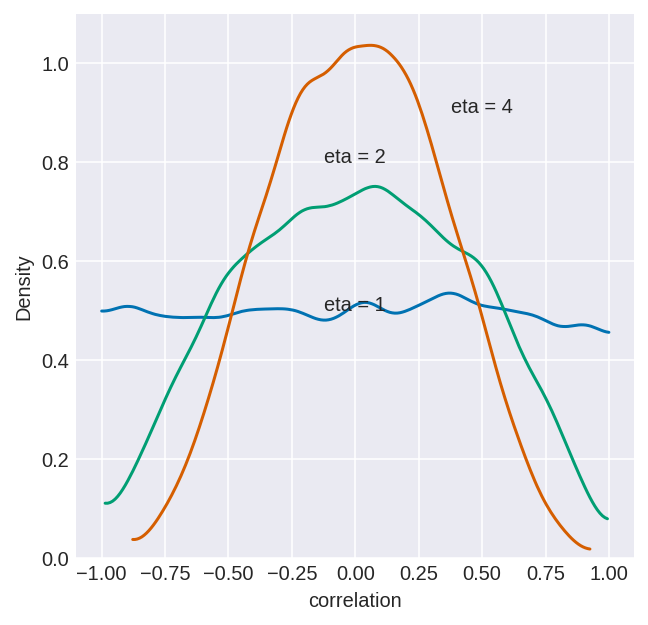

In [142]:
##########################
## corr prior analysis  ##
#########################

_, ax = plt.subplots(1, 1, figsize=(5, 5))
textloc = [[0, .5], [0, .8], [.5, .9]]
for eta, loc in zip([1, 2, 4], textloc):
    R = pm.LKJCorr.dist(n=2, eta=eta).random(size=10000)
    pm.kdeplot(R, ax=ax);
    ax.text(loc[0], loc[1], 'eta = %s'%(eta), horizontalalignment='center')

ax.set_ylim(0, 1.1)
ax.set_xlabel('correlation')
ax.set_ylabel('Density');

In [ ]:
# pm.Exponential prior analysis
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
plt.style.use('seaborn-darkgrid')
x = np.linspace(0, 3, 100)
for lam in [0.5, 1., 2.,10.]:
    pdf = st.expon.pdf(x, scale=1.0/lam)
    plt.plot(x, pdf, label=r'$\lambda$ = {}'.format(lam))
plt.xlabel('x', fontsize=12)
plt.ylabel('f(x)', fontsize=12)
plt.legend(loc=1)
plt.show()

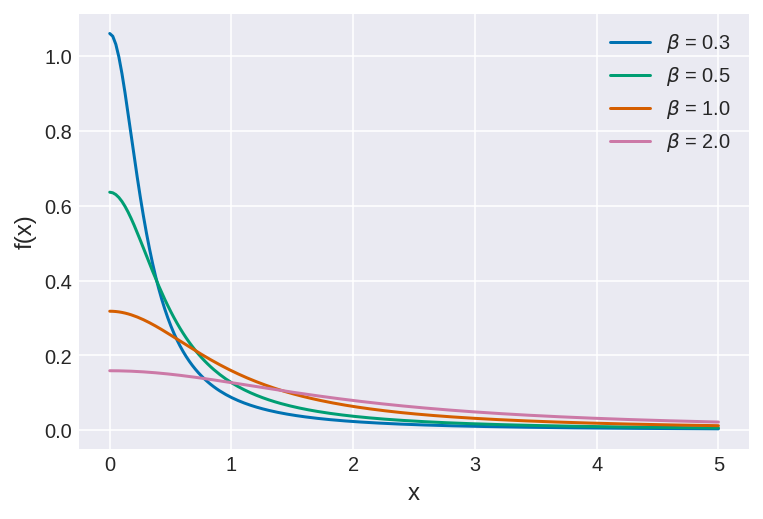

halfcauchy

   f(x \mid \beta) = \frac{2}{\pi \beta [1 + (\frac{x}{\beta})^2]}

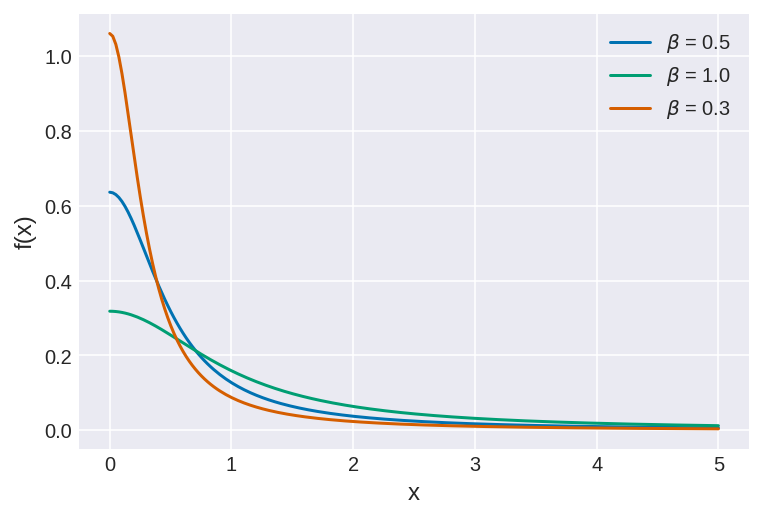

In [199]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
plt.style.use('seaborn-darkgrid')
x = np.linspace(0, 5, 200)
for b in [0.5, 1.0, .3]:
    pdf = st.cauchy.pdf(x, scale=b)
    plt.plot(x, pdf, label=r'$\beta$ = {}'.format(b))
plt.xlabel('x', fontsize=12)
plt.ylabel('f(x)', fontsize=12)
plt.legend(loc=1)
plt.show()

In [ ]:
# student t
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
plt.style.use('seaborn-darkgrid')
x = np.linspace(0, 5, 200)
sigmas = [1., 1., 2., 1.]
nus = [.5, 1., 1., 30.]
for sigma, nu in zip(sigmas, nus):
    pdf = st.t.pdf(x, df=nu, loc=0, scale=sigma)
    plt.plot(x, pdf, label=r'$\sigma$ = {}, $\nu$ = {}'.format(sigma, nu))
plt.xlabel('x', fontsize=12)
plt.ylabel('f(x)', fontsize=12)
plt.legend(loc=1)
plt.show()

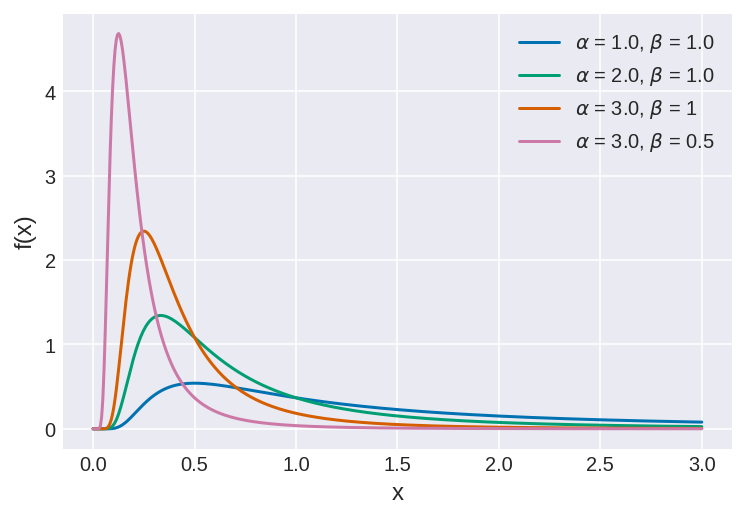

In [175]:
# Inverse Gamma Prior 
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st

plt.style.use('seaborn-darkgrid')
x = np.linspace(0, 3, 500)
alphas = [1., 2., 3., 3.]
betas = [1., 1., 1, .5]
for a, b in zip(alphas, betas):
    pdf = st.invgamma.pdf(x, a, scale=b)
    plt.plot(x, pdf, label=r'$\alpha$ = {}, $\beta$ = {}'.format(a, b))
plt.xlabel('x', fontsize=12)
plt.ylabel('f(x)', fontsize=12)
plt.legend(loc=1)
plt.show()

##### Model Definitions

In [97]:
# normal hierarchical modesl

with pm.Model() as normal_hierarchical_uniform:
    sd_dist = pm.HalfCauchy.dist(beta=2)
    packed_chol = pm.LKJCholeskyCov('chol_cov', eta=2, n=2, sd_dist=sd_dist)
    
    chol = pm.expand_packed_triangular(2, packed_chol, lower=True)
    cov = pm.Deterministic('cov_i',tt.dot(chol, chol.T))
    
    ab_bar = pm.Normal('ab_bar', mu=0, sd=1, shape=2)  # prior for average intercept and slope
    ab_farm = pm.MvNormal('ab_farm', mu=ab_bar, cov=cov, shape=(N_farms, 2)) # Population of varying effects
    # Shape needs to be (N_farm, 2) because we're getting back both a and b for each farm
    
    mu = ab_farm[:, 0][zero_farm_idx] +\
        ab_farm[:, 1][zero_farm_idx] * df.zprsum3.values  # linear model

    
    
    sd = pm.Uniform('sigma_NDVI', 0,2)      # prior NDVI stddev within farms
    NDVI = pm.Normal('NDVI', mu=mu, sd=sd, observed=df.zNDVIsum3)  # likelihood
    
    
with pm.Model() as normal_hierarchical_fixedsd:
    sd_dist = pm.HalfCauchy.dist(beta=2)
    packed_chol = pm.LKJCholeskyCov('chol_cov', eta=2, n=2, sd_dist=sd_dist)
    
    chol = pm.expand_packed_triangular(2, packed_chol, lower=True)
    cov = pm.Deterministic('cov_i',tt.dot(chol, chol.T))
    #==================================
    ab_bar = pm.Normal('ab_bar', mu=0, sd=1, shape=2)  # prior for average intercept and slope
    #==================================
    ab_farm = pm.MvNormal('ab_farm', mu=ab_bar, cov=cov, shape=(N_farms, 2)) # Population of varying effects
    # Shape needs to be (N_farm, 2) because we're getting back both a and b for each farm
    
    mu = ab_farm[:, 0][zero_farm_idx] +\
        ab_farm[:, 1][zero_farm_idx] * df.zprsum3.values  # linear model

    
    
    sd =.4      # prior NDVI stddev within farms
    NDVI = pm.Normal('NDVI', mu=mu, sd=sd, observed=df.zNDVIsum3)  # likelihood
    
    
    
    
with pm.Model() as normal_hierarchical_fixedsd_large:
    sd_dist = pm.HalfCauchy.dist(beta=2)
    packed_chol = pm.LKJCholeskyCov('chol_cov', eta=2, n=2, sd_dist=sd_dist)
    
    chol = pm.expand_packed_triangular(2, packed_chol, lower=True)
    cov = pm.Deterministic('cov_i',tt.dot(chol, chol.T))
    
    ab_bar = pm.Normal('ab_bar', mu=0, sd=1, shape=2)  # prior for average intercept and slope
    ab_farm = pm.MvNormal('ab_farm', mu=ab_bar, cov=cov, shape=(N_farms, 2)) # Population of varying effects
    # Shape needs to be (N_farm, 2) because we're getting back both a and b for each farm
    
    mu = ab_farm[:, 0][zero_farm_idx] +\
        ab_farm[:, 1][zero_farm_idx] * df.zprsum3.values  # linear model

    
    
    sd =.8      # prior u NDVI stddev within farms
    NDVI = pm.Normal('NDVI', mu=mu, sd=sd, observed=df.zNDVIsum3)  # likelihood
    
with pm.Model() as normal_hierarchical:
    sd_dist = pm.HalfCauchy.dist(beta=1) 
    packed_chol = pm.LKJCholeskyCov('chol_cov', eta=1, n=2, sd_dist=sd_dist)
    
    # compute the covariance matrix
    chol = pm.expand_packed_triangular(2, packed_chol, lower=True)
    Sigma_bar = pm.Deterministic('Sigma_bar',tt.dot(chol, chol.T))
    
    w_bar = pm.Normal('w_bar',mu=0,sd=3,shape=2)
    
    #sigma_ndvi = pm.Exponential('simga_ndvi', lam=10) 
    #sigma_ndvi = .4 # center prior around the .4 = s/(n)^.5
    sigma_ndvi = pm.InverseGamma('sigma_ndvi', alpha=3.,beta=1) 

    
    w_i = pm.MvNormal('w_i',w_bar,Sigma_bar,shape=(N_farms,2))
    NDVI_pred = df.zprsum3.values*w_i[:,1][zero_farm_idx] + w_i[:,0][zero_farm_idx]
    NDVI_i = pm.Normal('NDVI', NDVI_pred, sigma_ndvi, observed=df.zNDVIsum3)



In [177]:
# student T hierarhcical models

with pm.Model() as student_hierarchical_uniform:
    sd_dist = pm.HalfCauchy.dist(beta=2) 
    packed_chol = pm.LKJCholeskyCov('chol_cov', eta=2, n=2, sd_dist=sd_dist)
    
    # compute the covariance matrix
    chol = pm.expand_packed_triangular(2, packed_chol, lower=True)
    cov = tt.dot(chol, chol.T)
    
    # Extract the standard deviations and rho
    #sigma_ab = pm.Deterministic('sigma_farm', tt.sqrt(tt.diag(cov)))
    #corr = tt.diag(sigma_ab**-1).dot(cov.dot(tt.diag(sigma_ab**-1)))
    #r = pm.Deterministic('Rho', corr[np.triu_indices(2, k=1)])
    
    ab_bar = pm.Normal('ab_bar', mu=0, sd=1, shape=2)  # prior for average intercept and slope
    ab_farm = pm.MvNormal('ab_farm', mu=ab_bar, cov=cov, shape=(N_farms, 2)) # Population of varying effects
    # Shape needs to be (N_farm, 2) because we're getting back both a and b for each farm
    
    mu = ab_farm[:, 0][zero_farm_idx] +\
        ab_farm[:, 1][zero_farm_idx] * df.zprsum3.values  # linear model

    
    
    sd = pm.Uniform('sigma_NDVI', 0,2)      # prior NDVI stddev within farms
    NDVI = pm.Normal('NDVI', mu=mu, sd=sd, observed=df.zNDVIsum3)  # likelihood




with pm.Model() as student_t:
    sd_dist = pm.HalfCauchy.dist(beta=1) 
    packed_chol = pm.LKJCholeskyCov('chol_cov', eta=1, n=2, sd_dist=sd_dist)
    
    # compute the covariance matrix
    chol = pm.expand_packed_triangular(2, packed_chol, lower=True)
    Sigma_bar = pm.Deterministic('Sigma_bar',tt.dot(chol, chol.T))
    
    w_bar = pm.Normal('w_bar',mu=0,sd=3,shape=2)
    
    #sigma_ndvi = pm.Exponential('simga_ndvi', lam=10)
    #sigma_ndvi = pm.HalfNormal('sigma_ndvi', sd=.3)
    #sigma_ndvi = pm.HalfNormal('sigma_ndvi', sd=.5)
    #sigma_ndvi = .5
    sigma_ndvi = pm.InverseGamma('sigma_ndvi', alpha=3.,beta=1) # center prior around the .4 = s/(n)^.5
    
    
    w_i = pm.MvNormal('w_i',w_bar,Sigma_bar,shape=(N_farms,2))
    NDVI_pred = df.zprsum3.values*w_i[:,1][zero_farm_idx] + w_i[:,0][zero_farm_idx]
    NDVI_i = pm.StudentT('NDVI', nu=5, mu=NDVI_pred, sd=sigma_ndvi, observed=df.zNDVIsum3)

    
    
    
with pm.Model() as student_t_fixedsd:
    sd_dist = pm.HalfCauchy.dist(beta=1) 
    packed_chol = pm.LKJCholeskyCov('chol_cov', eta=1, n=2, sd_dist=sd_dist)
    
    # compute the covariance matrix
    chol = pm.expand_packed_triangular(2, packed_chol, lower=True)
    Sigma_bar = pm.Deterministic('Sigma_bar',tt.dot(chol, chol.T))
    
    w_bar = pm.Normal('w_bar',mu=0,sd=3,shape=2)
    
    sigma_ndvi = .4 # sample std from mean s/sqrt(n)

    
    w_i = pm.MvNormal('w_i',w_bar,Sigma_bar,shape=(N_farms,2))
    NDVI_pred = df.zprsum3.values*w_i[:,1][zero_farm_idx] + w_i[:,0][zero_farm_idx]
    
    NDVI_i = pm.StudentT('NDVI', nu=5, mu=NDVI_pred, sd=sigma_ndvi, observed=df.zNDVIsum3)

In [5]:
## GP #########################
## Haven't dialed this in yet:
###############################

with pm.Model() as student_t_GP:
    sd_dist = pm.HalfCauchy.dist(beta=1) 
    packed_chol = pm.LKJCholeskyCov('chol_cov', eta=1, n=2, sd_dist=sd_dist)
    
    # compute the covariance matrix
    chol = pm.expand_packed_triangular(2, packed_chol, lower=True)
    Sigma_bar = pm.Deterministic('Sigma_bar',tt.dot(chol, chol.T))
    
    w_bar = pm.Normal('w_bar',mu=0,sd=3,shape=2)
    
    sigma_ndvi = .4 # sample std from mean s/sqrt(n)

    
    w_i = pm.MvNormal('w_i',w_bar,Sigma_bar,shape=(N_farms,2))
    
    
    tau = pm.Gamma(90)
    Pstar = GP(mean=Pstar,cov=f(tau),observed=P)
    NDVI_pred = df.zprsum3.values*w_i[:,1][zero_farm_idx] + w_i[:,0][zero_farm_idx] + w_i[:,2][zero_farm_idx]*Pstar
    
    NDVI_i = pm.StudentT('NDVI', nu=5, mu=NDVI_pred, sd=sigma_ndvi, observed=df.zNDVIsum3)

NameError: name 'gamma' is not defined

In [184]:
#############################
# non hierarhcical models
#############################

with pm.Model() as nonh_student_t:

    w_bar=0
    #Sigma_bar = np.tile(np.array([[1,-.4],[-.4,1]]),(N_farms,1))
    Sigma_bar = np.array([[1,-.4],[-.4,1]])
    
    w_i = pm.MvNormal('w_i',w_bar,Sigma_bar,shape=(N_farms,2))
    sigma_ndvi = pm.InverseGamma('sigma_ndvi', alpha=3.,beta=1)
    
    NDVI_pred = df.zprsum3.values*w_i[:,1][zero_farm_idx] + w_i[:,0][zero_farm_idx]
    NDVI_i = pm.StudentT('NDVI', nu=5, mu=NDVI_pred, sd=sigma_ndvi, observed=df.zNDVIsum3)

with pm.Model() as nonh_Normal:

    w_bar=0
    #Sigma_bar = np.tile(np.array([[1,-.4],[-.4,1]]),(N_farms,1))
    Sigma_bar = np.array([[.5,-.4],[-.4,1]])
    
    w_i = pm.MvNormal('w_i',w_bar,Sigma_bar,shape=(N_farms,2))
    sigma_ndvi = pm.InverseGamma('sigma_ndvi', alpha=3.,beta=1)
    
    NDVI_pred = df.zprsum3.values*w_i[:,1][zero_farm_idx] + w_i[:,0][zero_farm_idx]
    NDVI_i = pm.Normal('NDVI', mu=NDVI_pred, sd=sigma_ndvi, observed=df.zNDVIsum3)
    
with pm.Model() as empericalbayes:

    w_bar=np.array([np.mean(a0), np.mean(b0)]) 
    # function below outputs a0,b0 slopes and intercepts
    # from normal non hierarchical regression
    Sigma_bar = np.cov(a0,b0)
    
    w_i = pm.MvNormal('w_i',w_bar,Sigma_bar,shape=(N_farms,2))
    sigma_ndvi = pm.InverseGamma('sigma_ndvi', alpha=3.,beta=1)
    
    NDVI_pred = df.zprsum3.values*w_i[:,1][zero_farm_idx] + w_i[:,0][zero_farm_idx]
    NDVI_i = pm.Normal('NDVI', mu=NDVI_pred, sd=sigma_ndvi, observed=df.zNDVIsum3)
    

##### Visualizing Model Architecture

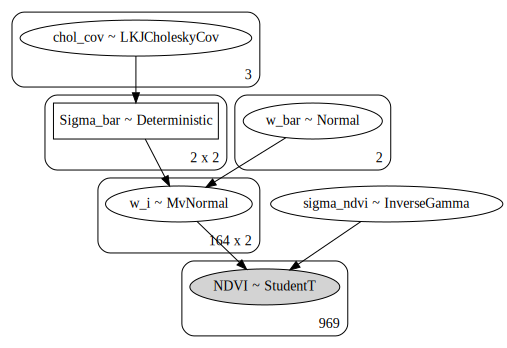

In [147]:
#pm.model_to_graphviz(nonh_student_t)
#pm.model_to_graphviz(m_2)
#pm.model_to_graphviz(m_3)
#pm.model_to_graphviz(m_4)
pm.model_to_graphviz(student_t)

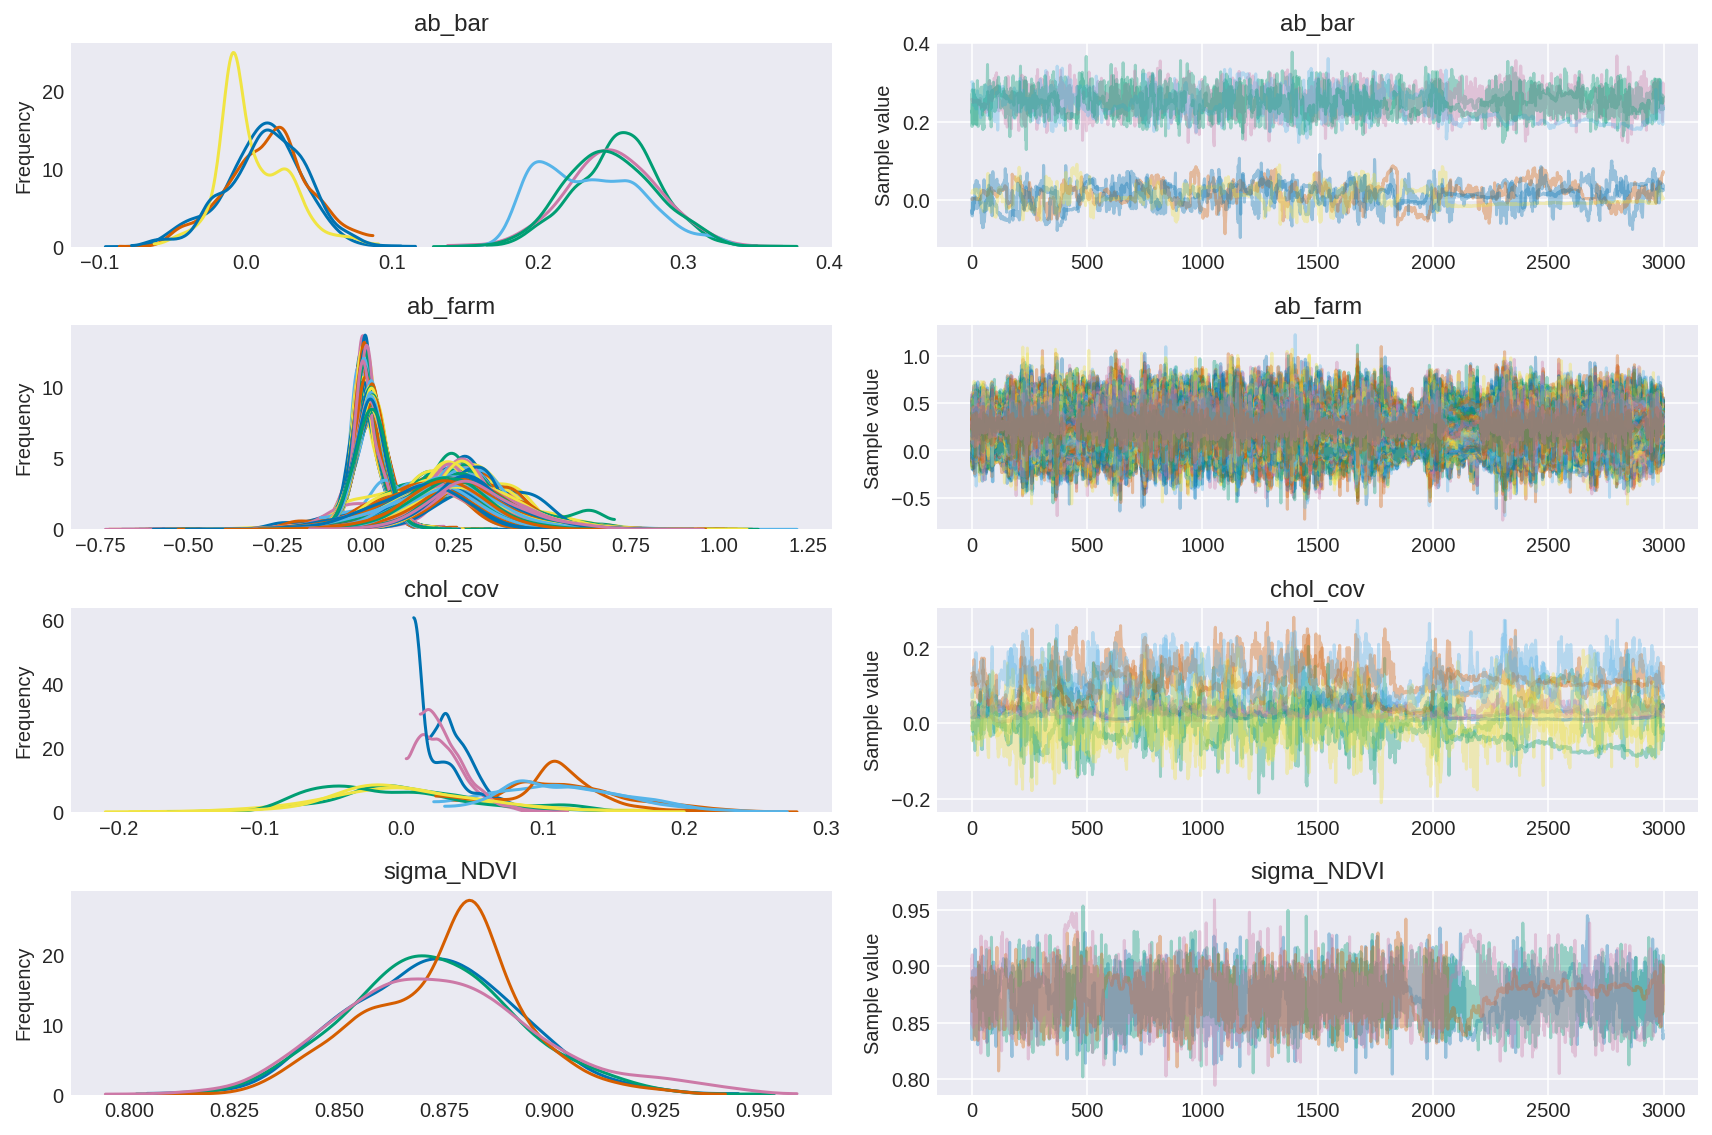

In [174]:
pm.traceplot(trace_student_hierarchical_uniform);

In [10]:
#the approximate method of variational inference is way faster!
with student_t_fixedsd:
    advifit = pm.fit(method="advi")

Average Loss = 23.39: 100%|██████████| 10000/10000 [00:07<00:00, 1255.66it/s]
Finished [100%]: Average Loss = 23.388


In [401]:
with normal_hierarchical_fixedsd_large:
    trace_normal_hierarchical_fixedsd_large = pm.sample(5000,tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ab_farm, ab_bar, chol_cov]
Sampling 4 chains: 100%|██████████| 24000/24000 [20:17<00:00,  4.40draws/s]  
There were 1720 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.4911923177451736, but should be close to 0.8. Try to increase the number of tuning steps.
There were 597 divergences after tuning. Increase `target_accept` or reparameterize.
There were 559 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.619636718637988, but should be close to 0.8. Try to increase the number of tuning steps.
There were 343 divergences after tuning. Increase `target_accept` or reparameterize.
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estim

In [394]:
with normal_hierarchical_fixedsd:
    trace_normal_hierarchical_fixedsd = pm.sample(5000,tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ab_farm, ab_bar, chol_cov]
Sampling 4 chains: 100%|██████████| 24000/24000 [04:58<00:00, 80.42draws/s] 
There were 1198 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.4845340202136235, but should be close to 0.8. Try to increase the number of tuning steps.
There were 768 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5994496238303825, but should be close to 0.8. Try to increase the number of tuning steps.
There were 64 divergences after tuning. Increase `target_accept` or reparameterize.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8882183932764616, but should be close to 0.8. Try to increase the

In [28]:
with student_hierarchical_uniform:
    trace_student_hierarchical_uniform = pm.sample(4000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_NDVI, ab_farm, ab_bar, chol_cov]
Sampling 4 chains: 100%|██████████| 16000/16000 [05:48<00:00, 14.04draws/s] 
There were 385 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5392526746854092, but should be close to 0.8. Try to increase the number of tuning steps.
There were 45 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9003105731066097, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1105 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.468909794654744, but should be close to 0.8. Try to increase the number of tuning steps.
There were 251 divergences after tuning. Increas

In [20]:
with student_hierarchical_uniform:
    mean_field_student_hierarchical_uniform = pm.fit(method='advi')

Average Loss = 1,450.5: 100%|██████████| 10000/10000 [00:09<00:00, 1056.54it/s]
Finished [100%]: Average Loss = 1,450.2


In [58]:
pm.fit?

In [29]:
with normal_hierarchical_uniform:
    trace_normal_hierarchical_uniform = pm.sample(3000,tune=1000)

NameError: name 'normal_hierarchical_uniform' is not defined

In [154]:
with normal_hierarchical:
    approx_h_normal = pm.fit(method='fullrank_advi')

Average Loss = 1,360.1: 100%|██████████| 10000/10000 [00:43<00:00, 227.42it/s]  
Finished [100%]: Average Loss = 1,360


In [159]:
with normal_hierarchical:
    approx_h_normal_advi = pm.fit(method='advi')

Average Loss = 1,445.3: 100%|██████████| 10000/10000 [00:09<00:00, 1049.09it/s]
Finished [100%]: Average Loss = 1,444.7


In [98]:
with normal_hierarchical:
    trace_h_normal = pm.sample(2000, tune=500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w_i, sigma_ndvi, w_bar, chol_cov]
Sampling 4 chains: 100%|██████████| 10000/10000 [02:55<00:00, 56.87draws/s]
There were 431 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5301389024066148, but should be close to 0.8. Try to increase the number of tuning steps.
There were 302 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6456899161223123, but should be close to 0.8. Try to increase the number of tuning steps.
There were 341 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.43081454753996945, but should be close to 0.8. Try to increase the number of tuning steps.
There were 61 divergences after tuning. Increase `ta

In [203]:
with student_t:
    trace_st = pm.sample(3000, tune=300)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w_i, sigma_ndvi, w_bar, chol_cov]
Sampling 4 chains: 100%|██████████| 13200/13200 [06:56<00:00, 31.66draws/s]
There were 57 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9025568739097319, but should be close to 0.8. Try to increase the number of tuning steps.
There were 226 divergences after tuning. Increase `target_accept` or reparameterize.
There were 342 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6473721429473953, but should be close to 0.8. Try to increase the number of tuning steps.
There were 300 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


In [257]:
with student_t:
    trace_st3 = pm.sample(5000,tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w_i, sigma_ndvi, w_bar, chol_cov]
Sampling 4 chains: 100%|██████████| 24000/24000 [05:32<00:00, 72.21draws/s] 
There were 433 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6038902279402307, but should be close to 0.8. Try to increase the number of tuning steps.
There were 222 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3286 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.28952528787608506, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1577 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.40042773395801057, but should be close to 0.8. Try to 

In [ ]:
with student_t_fixedsd:
    trace_stfixed = pm.sample(5000, tune=1000)

In [ ]:
with nonh_student_t:
    trace_nonh_student_t = pm.sample(5000,tune=1000)


In [ ]:
with nonh_Normal:
    trace_nonh_normal = pm.sample(5000,tune=1000)

In [192]:
with empericalbayes:
    trace_empericalbayes = pm.sample(2000, tune=500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_ndvi, w_i]
Sampling 4 chains: 100%|██████████| 10000/10000 [00:15<00:00, 625.90draws/s]


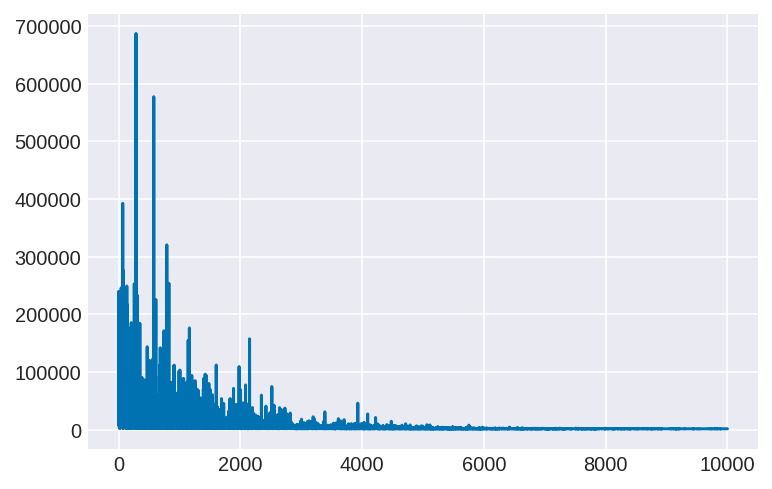

In [160]:
# advi
plt.plot(approx_h_normal_advi.hist);

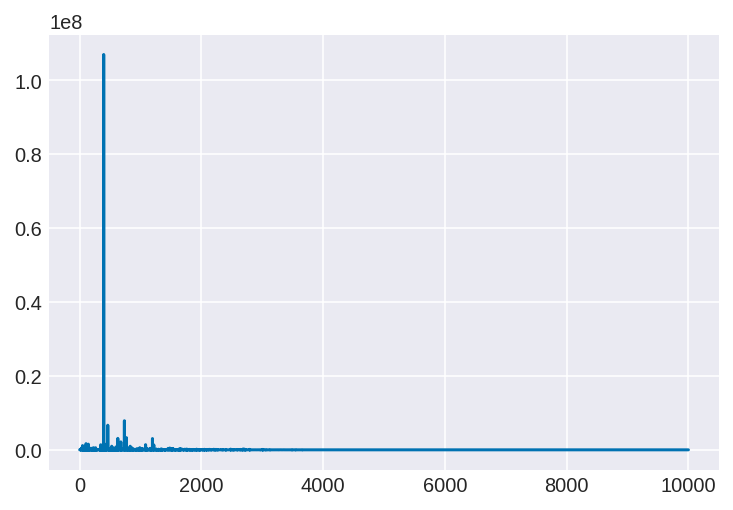

In [155]:
plt.plot(approx_h_normal.hist);

In [32]:
# my function from westernwheat

def linear_pixel(df, p,c,column_x,column_y, LOO=False, cluster=True):
    """
    =========================================================
    Compute simple OLS pixel wise for given pixel/farm p, and cluster c.
    
    LeaveOneOut implented for CV studies. 
    
    if LOO:
        return mu_params_pixel, C_pixel, y_train, x_train, y_test, x_test, n
    =========================================================
    """
    if cluster:
        dfc = df[df.cluster==c]
        dfp = dfc.loc[dfc.pixel==p]
    else:
        dfp = df.loc[df.pixel==p]
    # first mask out potential nan values
    mask = ~np.isnan(dfp[column_x].values) & ~np.isnan(dfp[column_y].values)
    x = dfp[column_x].values[mask]
    y = dfp[column_y].values[mask]
    
    
    if LOO == True:

        # delete one of the y and x values before fitting line
        
        n = np.random.randint(0,y.shape[0]) # one data point left out of training set
        y_test = y[n]   # selecting n test set
        y = np.delete(y,n)  # erase value indexed at n from training set
        x_test = x[n] # selecting n test data
        x = np.delete(x,n) # delete corresponding x value 
            
    G = np.ones_like(x)
    G = np.array((G,x)).T
    # ml2 = [alpha, beta] parameters for least squares
    # ml2 = (G.T@G)-1 @ G.T @ d
    # least squares in matrix form
    A = np.matmul(np.linalg.inv(np.matmul(G.T,G)),  G.T)
    mu_params = np.matmul(A,y)
    mu_params_pixel = mu_params

    #plt.plot(x,mu_params[0]+mu_params[1]*x)
    #plt.show();
    # check
    #stat = stats.linregress(x=x,y=y)
    #plt.plot(x,stat[1]+stat[0]*x);
    
    # variance in y
    # p.31
    #Cov(ml2) = (Gw.T@Gw)-1
    # assumption iid normal data errors
    # Cov(ml2) = var*(G.T@G)-1
    C =  y.var() * np.linalg.inv(np.matmul(G.T,G))
    C_pixel = C  
    
    if LOO==True:
        return mu_params_pixel, C_pixel, y, x, y_test, x_test, n
    
    else: 
        return mu_params_pixel, C_pixel
    
    
######
# OLS 
######

#############################################
# compute slope int directly from pixel level
##############################################
a0b0 = []    
for p in unique_farm_idx:
        mu_params,_ = linear_pixel(df,p,c=0,column_x='zprsum3',column_y='zNDVIsum3', cluster=False)
        a0b0.append(mu_params)
        
# OLS results
ab = np.array(a0b0)
a0, b0 = ab[:,0], ab[:,1]

In [191]:
np.cov(a0,b0), np.mean(a0), np.mean(b0)

(array([[0.00217143, 0.00454472],
        [0.00454472, 0.05330569]]), 0.007817374456525517, 0.24509224385384976)

In [187]:
########################
# Another PYmc result
#######################
#a1b1 = trace_nonh_student_t['w_i'].mean(axis=0)
#a1 = a1b1[:, 0]
#b1 = a1b1[:, 1]


####################
## VI results
###################

w_i_VI = approx_h_normal.sample(1000)['w_i']
w = np.mean(w_i_VI, axis=0)
a0 = w[:,0]
b0 = w[:,1]

#w_i_advi = approx_h_normal_advi.sample(1000)['w_i']
#w_advi = np.mean(w_i_advi, axis=0)
#a0 = w_advi[:,0]
#b0 = w_advi[:,1]

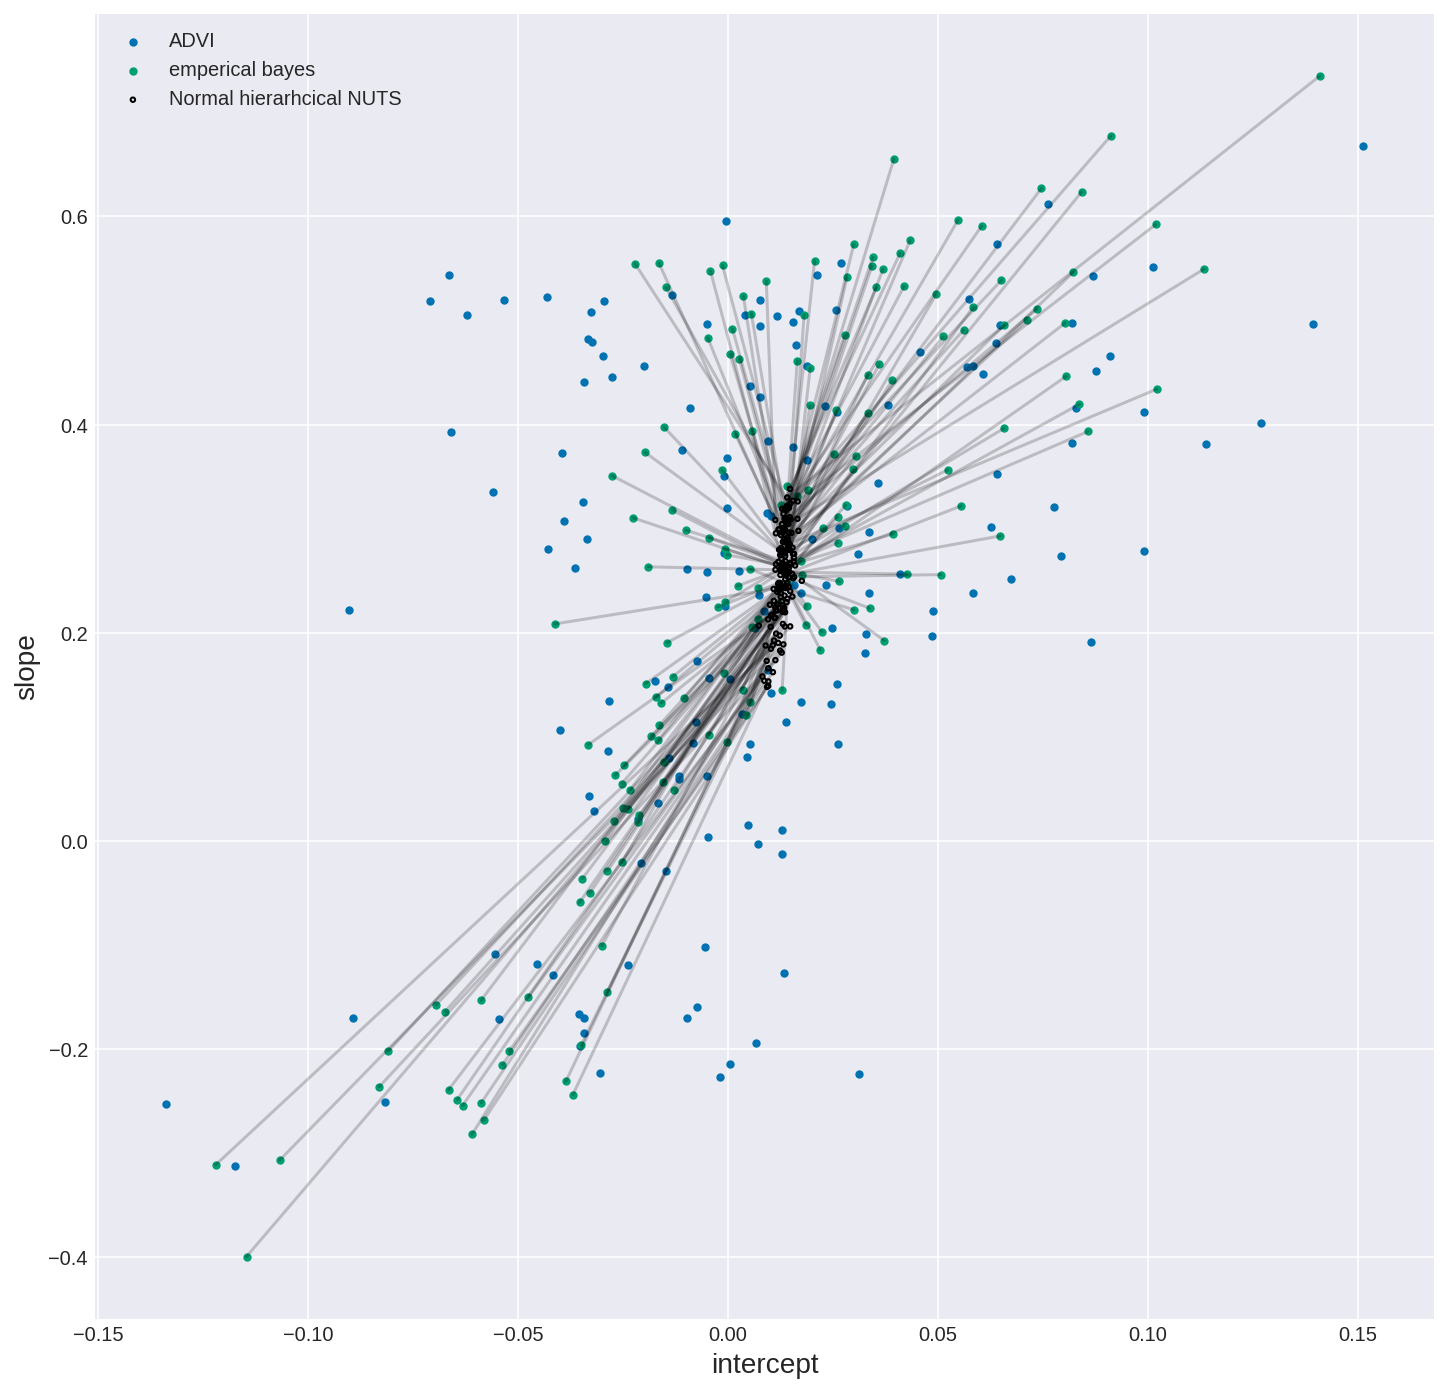

In [193]:
a1b1 = trace_empericalbayes['w_i'].mean(axis=0)
a1 = a1b1[:, 0]
b1 = a1b1[:, 1]

# extract posterior means of partially pooled estimates
a2b2 = trace_h_normal['w_i'].mean(axis=0)
a2 = a2b2[:, 0]
b2 = a2b2[:, 1]

# plot both and connect with lines
_, ax = plt.subplots(1, 1, figsize=(12,12))
ax.scatter(a0,b0,label='ADVI', s=10)
ax.scatter(a1, b1, label='emperical bayes', s=10)
ax.scatter(a2, b2, label='Normal hierarhcical NUTS', s=5, 
           facecolors='none', edgecolors='k', lw=1)
#ax.scatter(a0,b0, label='OLS non hier', s=5)

ax.plot([a1, a2], [b1, b2], 'k-', alpha=.2)
ax.set_xlabel('intercept', fontsize=14)
ax.set_ylabel('slope', fontsize=14)
#ax.set_title('studentT = .3 vs. studentT sigma=RV')
#ax.set_xlim(-.3,.3)
#ax.set_ylim(-.5,.5)
ax.legend();

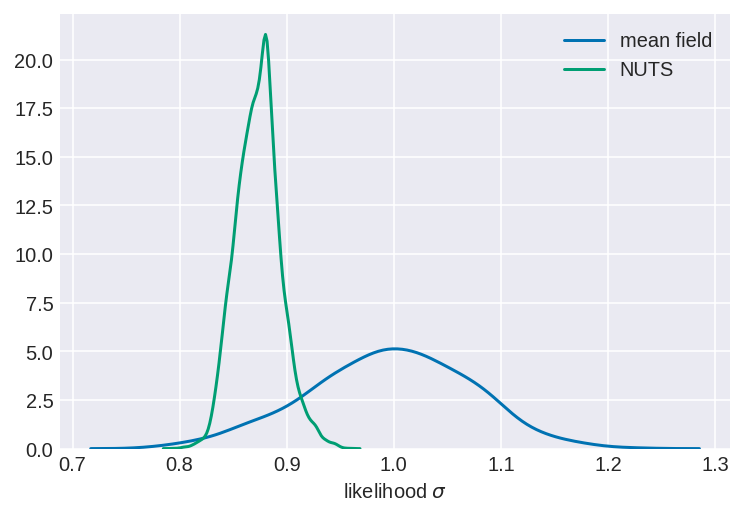

In [150]:
sigma = mean_field_student_hierarchical_uniform.sample(1000)['sigma_NDVI']
sns.kdeplot(sigma, label='mean field')
sns.kdeplot(trace_student_hierarchical_uniform['sigma_NDVI'], label='NUTS')
plt.xlabel('likelihood ' + r'$\sigma$');

In [375]:
sigma = mean_field_student_hierarchical_uniform.sample(1000)['sigma_NDVI']
sns.kdeplot(sigma, label='mean field')
sns.kdeplot(trace_student_hierarchical_uniform['sigma_NDVI'], label='NUTS');

Complete Shrinkage. Two obvious possibilities: 

1.) I am letting the model choose too high of sigma 

2.) my farm level data is junk relative to the group level data.

In [374]:
#pm.traceplot(trace_st3);

In [373]:
#pm.traceplot(trace_st2);

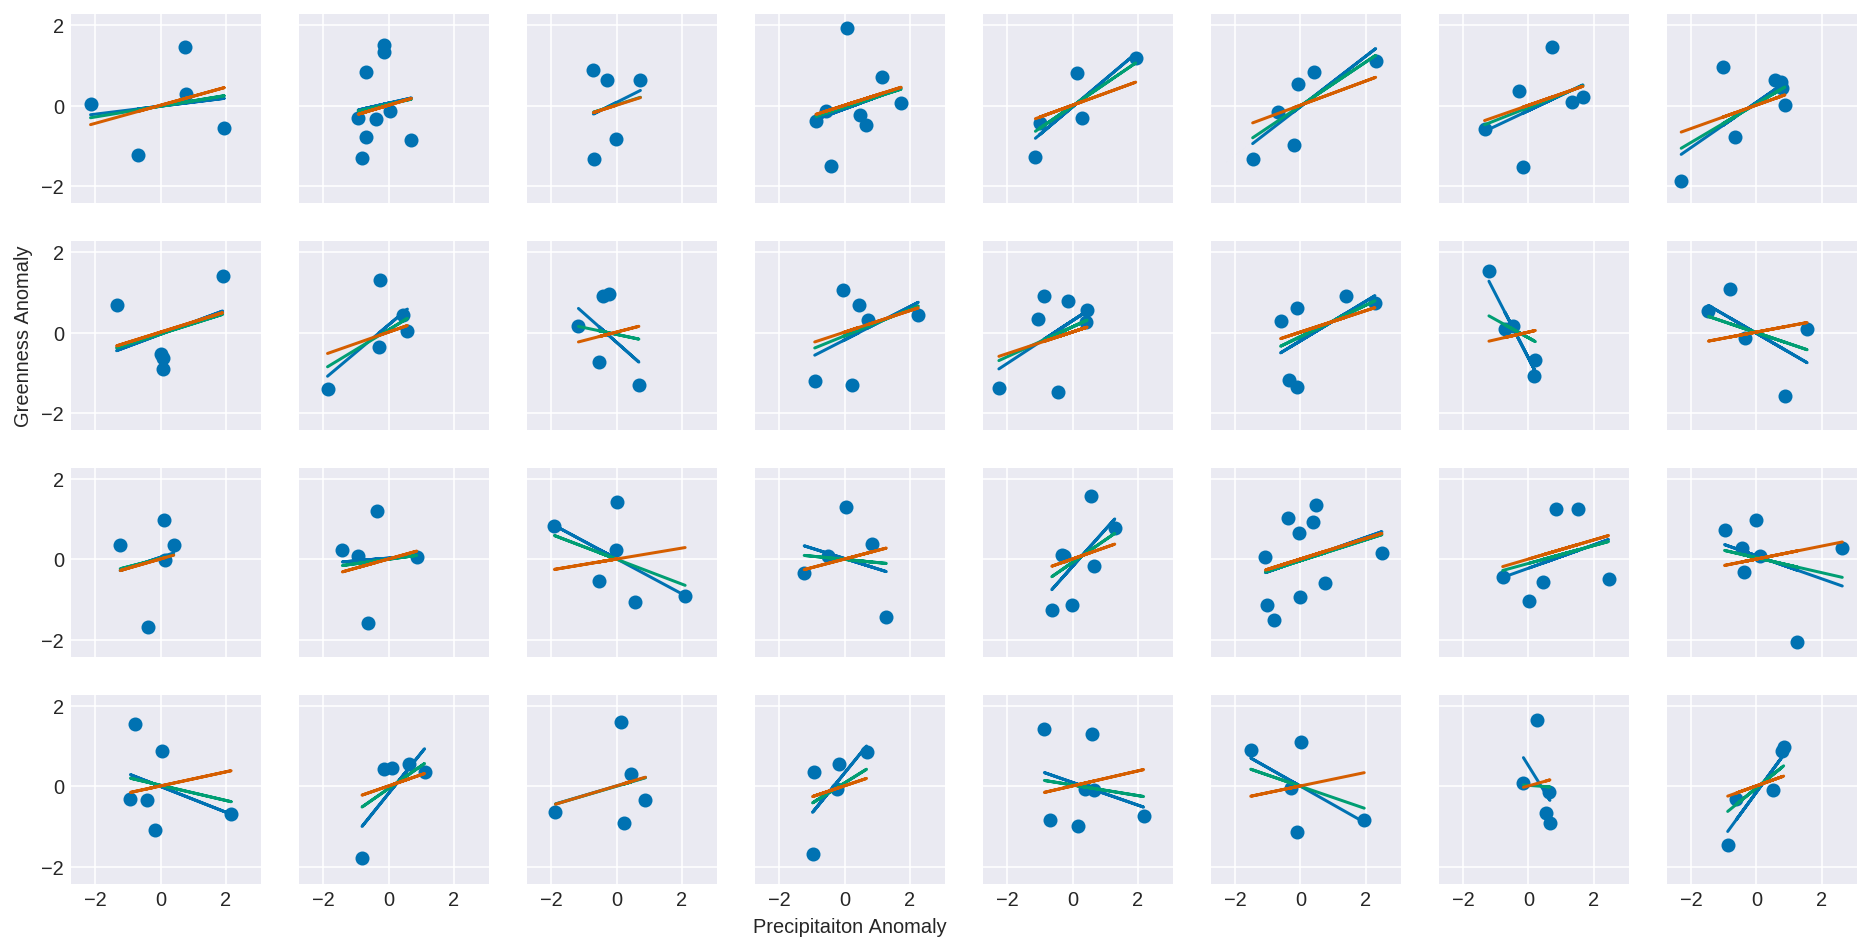

In [55]:
fig, ax = plt.subplots(nrows=4,ncols=8,sharex=True,sharey=True, figsize=(16,8))
num=50  # farm number to start at. Can go up to 163-ncols
count = num # start count at initial farm  
for i,farm in enumerate(range(num,num+8)):
    for j,farmj in enumerate(range(num,num+4)):
        count += 1
        dfp = df.loc[df.farm==count]
        x = dfp.zprsum3
        ax[j,i].scatter(x,dfp.zNDVIsum3)
        ax[j,i].plot(x, a0[count]+b0[count]*x)
        ax[j,i].plot(x, a1[count]+b1[count]*x)
        ax[j,i].plot(x, a2[count]+b2[count]*x)
        ax[3,3].set_xlabel('Precipitaiton Anomaly')
        ax[1,0].set_ylabel('Greenness Anomaly');

In [381]:

comp_df = pm.compare({student_hierarchical_uniform:trace_normal_hierarchical_uniform,
                      student_t:trace_st2,
                      student_t_fixedsd:trace_stfixed,
                      nonh_student_t:trace_nonh_student_t,
                        })

comp_df.loc[:,'model'] = pd.Series(['studentT_hierarchical_uniform','studentT_hierarchical', 
                                    'studentT_hierarchical_fixedsd','studentT_nonhierarchical',
                                    ])

comp_df = comp_df.set_index('model')
comp_df

/home/brian/anaconda2/envs/py36/lib/python3.6/site-packages/pymc3/stats.py:218: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
/home/brian/anaconda2/envs/py36/lib/python3.6/site-packages/pymc3/stats.py:218: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
/home/brian/anaconda2/envs/py36/lib/python3.6/site-packages/pymc3/stats.py:218: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


,WAIC,pWAIC,dWAIC,weight,SE,dSE,var_warn
model,,,,,,,
studentT_hierarchical_uniform,2501.36,18.73,0,1,34.12,0,0
studentT_hierarchical,2586.13,31.94,84.76,0,37.93,6.81,1
studentT_nonhierarchical,2974.3,261.72,472.94,0,37.71,18.77,1
studentT_hierarchical_fixedsd,3281.14,247.21,779.77,0,87.59,57.96,1


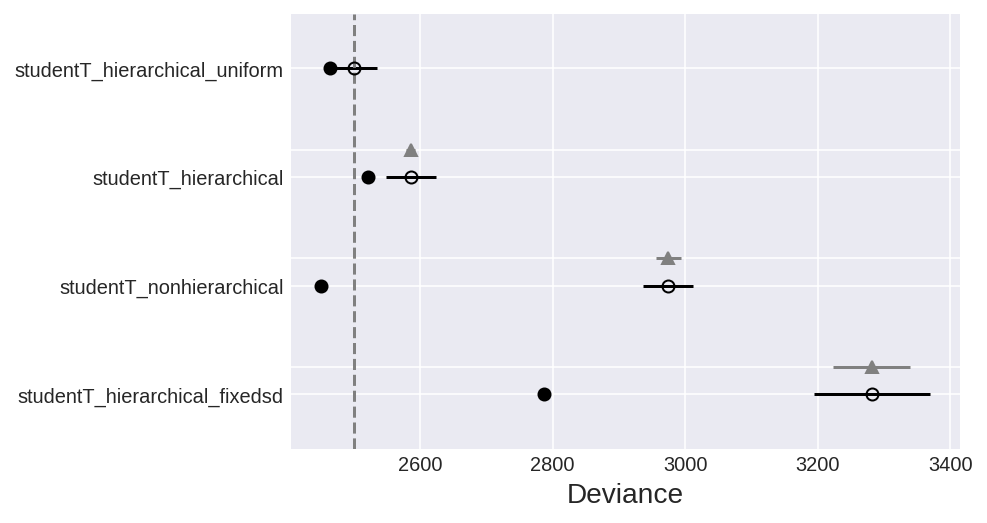

In [390]:
pm.compareplot(comp_df);

/home/brian/anaconda2/envs/py36/lib/python3.6/site-packages/pymc3/stats.py:299: UserWarning: Estimated shape parameter of Pareto distribution is
        greater than 0.7 for one or more samples.
        You should consider using a more robust model, this is because
        importance sampling is less likely to work well if the marginal
        posterior and LOO posterior are very different. This is more likely to
        happen with a non-robust model and highly influential observations.
  happen with a non-robust model and highly influential observations.""")
/home/brian/anaconda2/envs/py36/lib/python3.6/site-packages/pymc3/stats.py:299: UserWarning: Estimated shape parameter of Pareto distribution is
        greater than 0.7 for one or more samples.
        You should consider using a more robust model, this is because
        importance sampling is less likely to work well if the marginal
        posterior and LOO posterior are very different. This is more likely to
        happen w

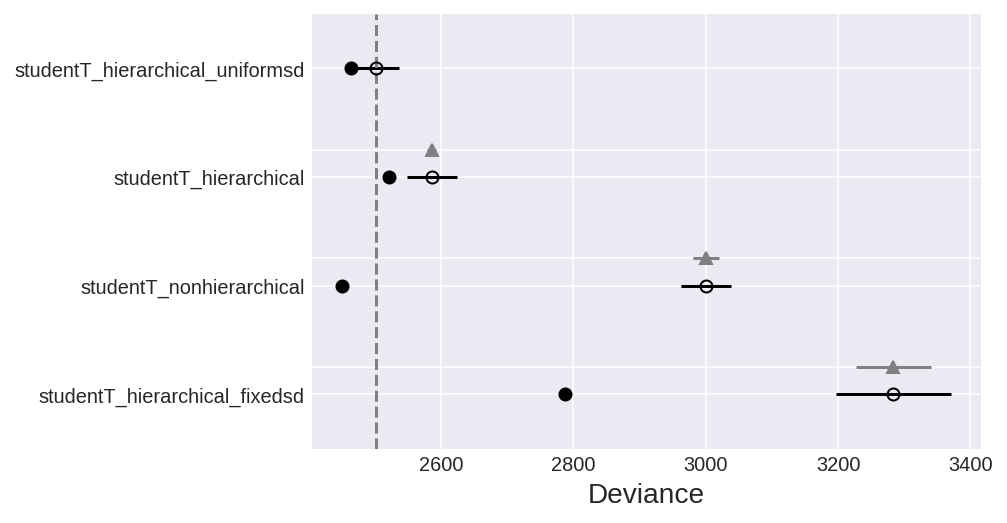

In [389]:

comp_df_loo = pm.compare({student_hierarchical_uniform:trace_normal_hierarchical_uniform,
                      student_t:trace_st2,
                      student_t_fixedsd:trace_stfixed,
                      nonh_student_t:trace_nonh_student_t,
                        }, ic='LOO')

comp_df_loo.loc[:,'model'] = pd.Series(['studentT_hierarchical_uniformsd','studentT_hierarchical', 
                                    'studentT_hierarchical_fixedsd','studentT_nonhierarchical',
                                    ])

comp_df_loo = comp_df_loo.set_index('model')

pm.compareplot(comp_df_loo)

In [402]:
normal_df = pm.compare({normal_hierarchical:trace_h_normal,
                       empericalbayes:trace_empericalbayes, 
                       nonh_Normal: trace_nonh_normal,
                       normal_hierarchical_uniform: trace_normal_hierarchical_uniform,
                       normal_hierarchical_fixedsd: trace_normal_hierarchical_fixedsd,
                       normal_hierarchical_fixedsd_large: trace_normal_hierarchical_fixedsd_large})

normal_df.loc[:,'model']=pd.Series(['normal_hierarchical','normal_emperical_bayes',
                                   'normal_nonhierarchical','normal_hierarchical_uniformsd',
                                   'normal_hierarchical_fixedsd_small',
                                   'normal_hierarchical_fixedsd_large'])

normal_df = normal_df.set_index('model')


/home/brian/anaconda2/envs/py36/lib/python3.6/site-packages/pymc3/stats.py:218: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
/home/brian/anaconda2/envs/py36/lib/python3.6/site-packages/pymc3/stats.py:218: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
/home/brian/anaconda2/envs/py36/lib/python3.6/site-packages/pymc3/stats.py:218: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
/home/brian/anaconda2/envs/py36/lib/python3.6/site-pack

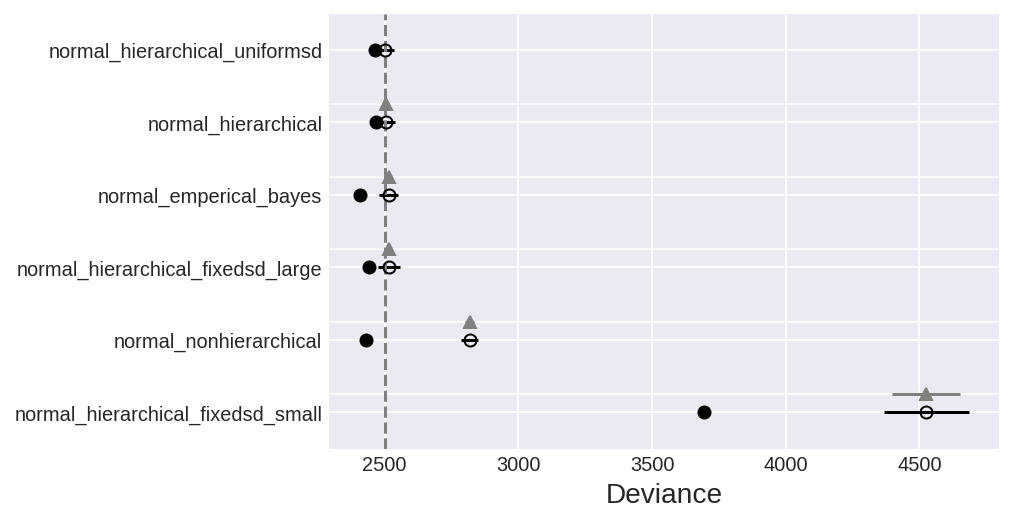

In [403]:
pm.compareplot(normal_df);

In [404]:
normal_df_LOO = pm.compare({normal_hierarchical:trace_h_normal,
                       empericalbayes:trace_empericalbayes, 
                       nonh_Normal: trace_nonh_normal,
                       normal_hierarchical_uniform: trace_normal_hierarchical_uniform,
                        normal_hierarchical_fixedsd: trace_normal_hierarchical_fixedsd,
                           normal_hierarchical_fixedsd_large: trace_normal_hierarchical_fixedsd_large},ic='LOO')

normal_df_LOO.loc[:,'model']=pd.Series(['normal_hierarchical_invgammasd','normal_emperical_bayes',
                                   'normal_nonhierarchical','normal_hierarchical_uniformsd',
                                       'normal_hierarchical_fixed_sd', 'normal_hierarchical_fixed_sd_large'])

normal_df_LOO = normal_df_LOO.set_index('model')
normal_df_LOO

/home/brian/anaconda2/envs/py36/lib/python3.6/site-packages/pymc3/stats.py:299: UserWarning: Estimated shape parameter of Pareto distribution is
        greater than 0.7 for one or more samples.
        You should consider using a more robust model, this is because
        importance sampling is less likely to work well if the marginal
        posterior and LOO posterior are very different. This is more likely to
        happen with a non-robust model and highly influential observations.
  happen with a non-robust model and highly influential observations.""")
/home/brian/anaconda2/envs/py36/lib/python3.6/site-packages/pymc3/stats.py:299: UserWarning: Estimated shape parameter of Pareto distribution is
        greater than 0.7 for one or more samples.
        You should consider using a more robust model, this is because
        importance sampling is less likely to work well if the marginal
        posterior and LOO posterior are very different. This is more likely to
        happen w

,LOO,pLOO,dLOO,weight,SE,dSE,shape_warn
model,,,,,,,
normal_hierarchical_uniformsd,2502.13,19.12,0,0.88,34.14,0,1
normal_hierarchical_invgammasd,2505.06,19.25,2.93,0.12,34.99,3.95,1
normal_hierarchical_fixed_sd_large,2518.5,38.92,16.37,0,41.07,7.76,1
normal_emperical_bayes,2518.67,55.86,16.54,0,34.99,6.07,0
normal_nonhierarchical,2862.18,216.71,360.05,0,34.89,17.03,1
normal_hierarchical_fixed_sd,4603.16,455.21,2101.03,0,160.51,130.32,1


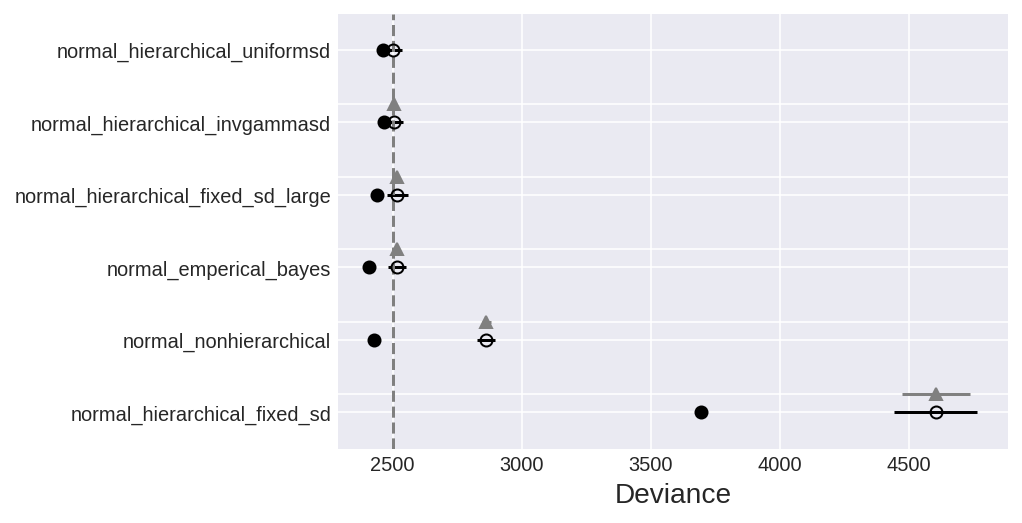

In [406]:
pm.compareplot(normal_df_LOO);

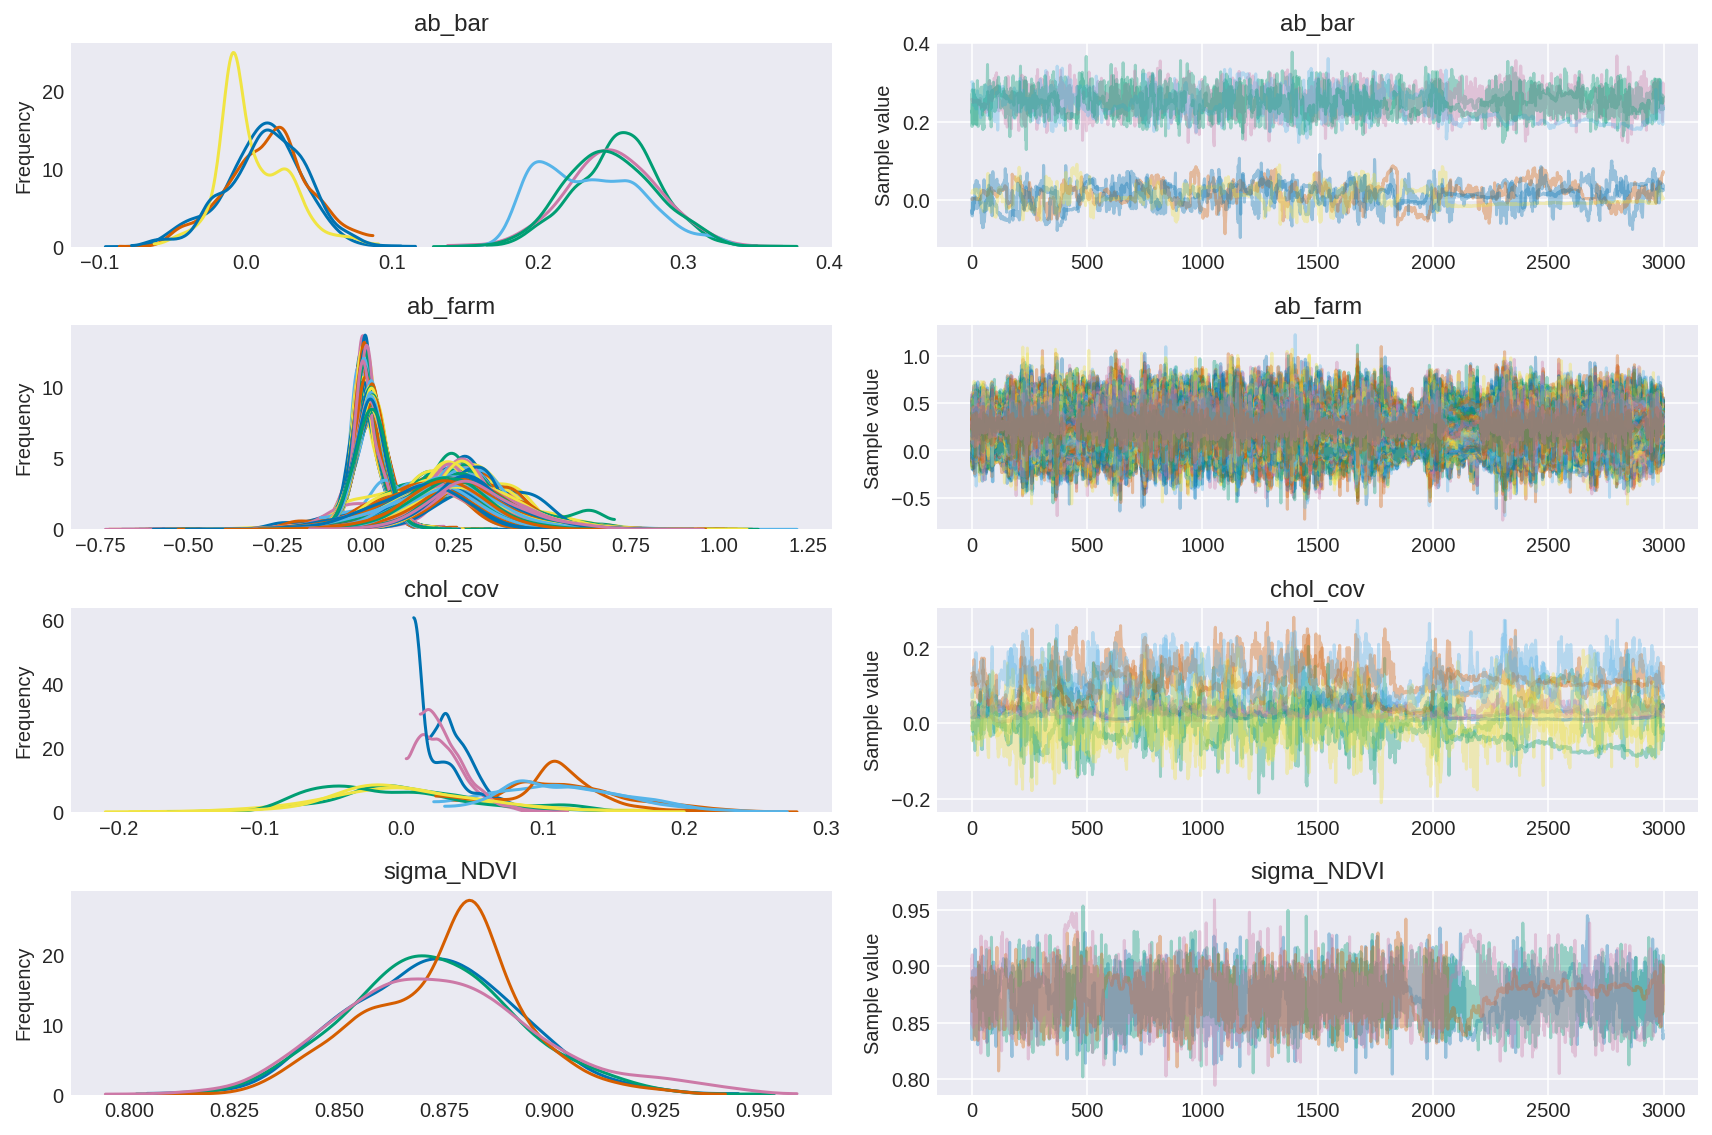

In [60]:
pm.traceplot(trace_student_hierarchical_uniform);

In [110]:

means = mean_field_student_hierarchical_uniform.bij.rmap(mean_field_student_hierarchical_uniform.mean.eval())
sds = mean_field_student_hierarchical_uniform.bij.rmap(mean_field_student_hierarchical_uniform.std.eval())

means = approx_h_normal.bij.rmap(approx_h_normal.mean.eval())
sds = approx_h_normal.bij.rmap(approx_h_normal.std.eval())


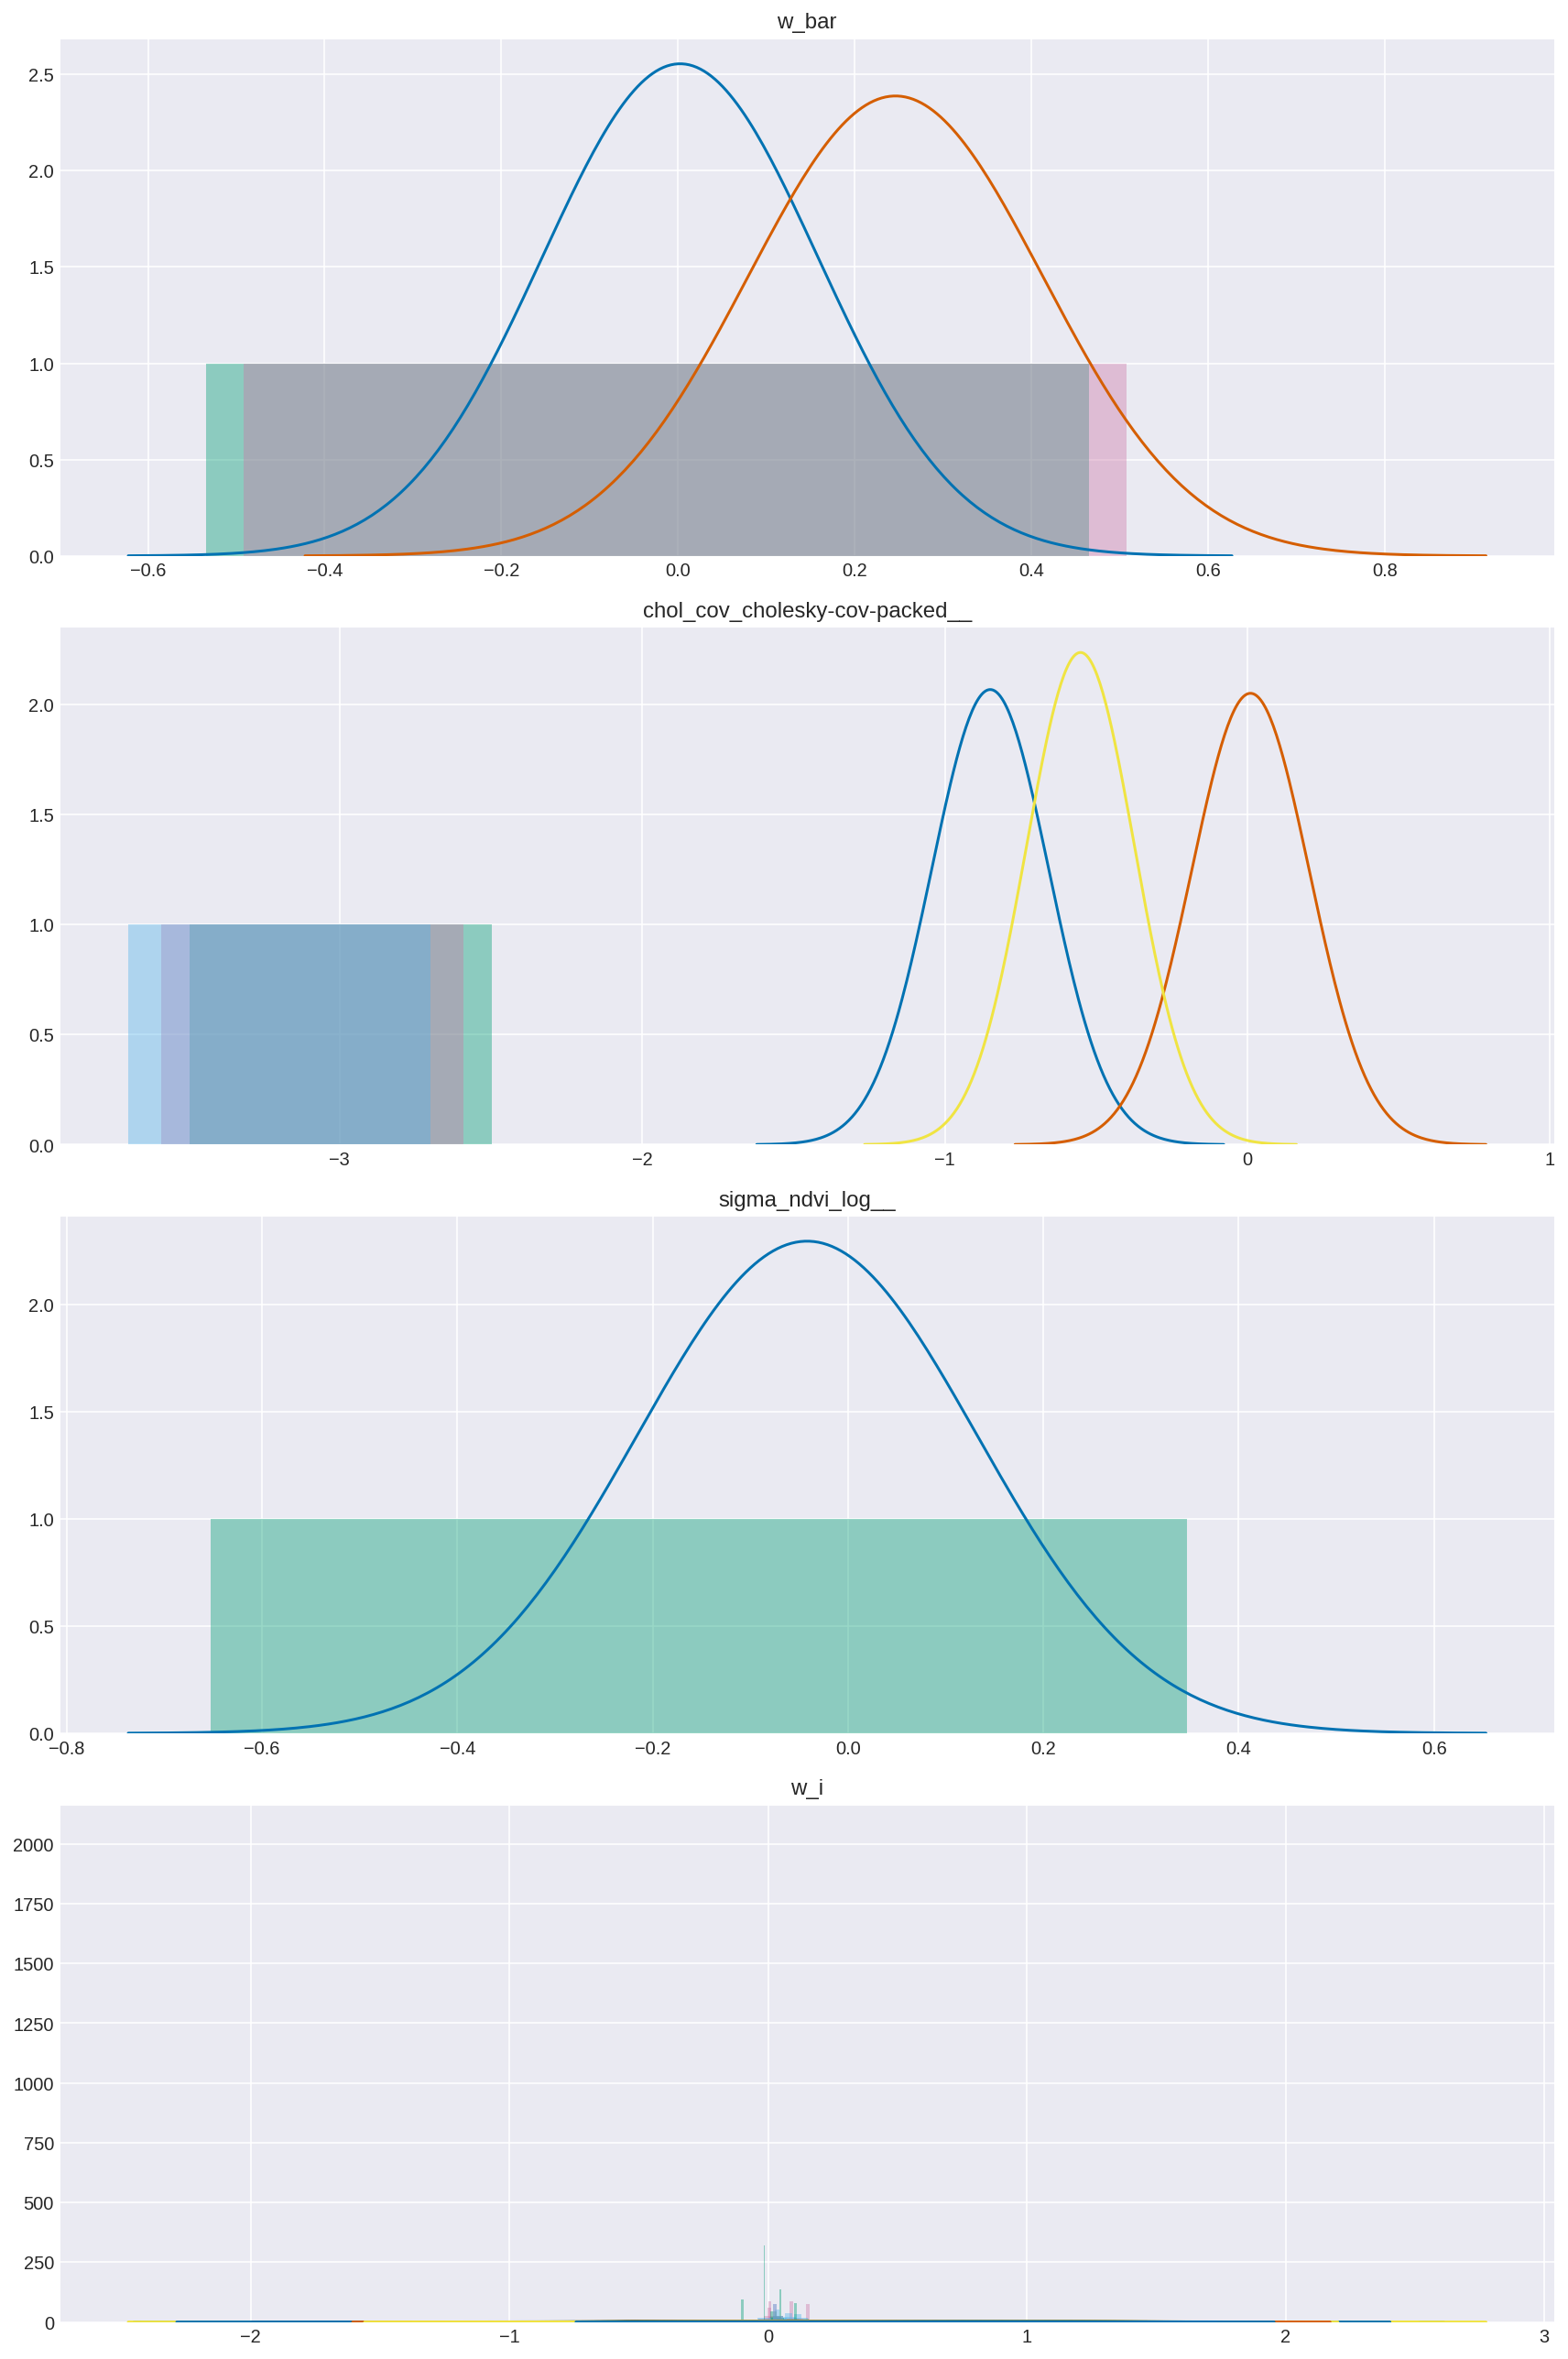

In [111]:

from scipy import stats
import seaborn as sns
varnames = means.keys()
fig, axs = plt.subplots(nrows=len(varnames), figsize=(12, 18))
for var, ax in zip(varnames, axs):
    mu_arr = means[var]
    sigma_arr = sds[var]
    ax.set_title(var)
    for i, (mu, sigma) in enumerate(zip(mu_arr.flatten(), sigma_arr.flatten())):
        sd3 = (-4*sigma + mu, 4*sigma + mu)
        x = np.linspace(sd3[0], sd3[1], 300)
        y = stats.norm(mu, sigma).pdf(x)
        ax.plot(x, y)
        if trace_h_normal[var].ndim > 1:
            t = trace_h_normal[var][i]
            
        else:
            t = trace_h_normal[var]
            
        sns.distplot(t[:1], kde=False, norm_hist=True, ax=ax)
        
fig.tight_layout()



In [145]:
d = df.drop_duplicates(subset='pixel')

w = np.mean(w_i_VI, axis=0)
a1 = w[:,0]
b1 = w[:,1].mean(axis=0)[:,1])

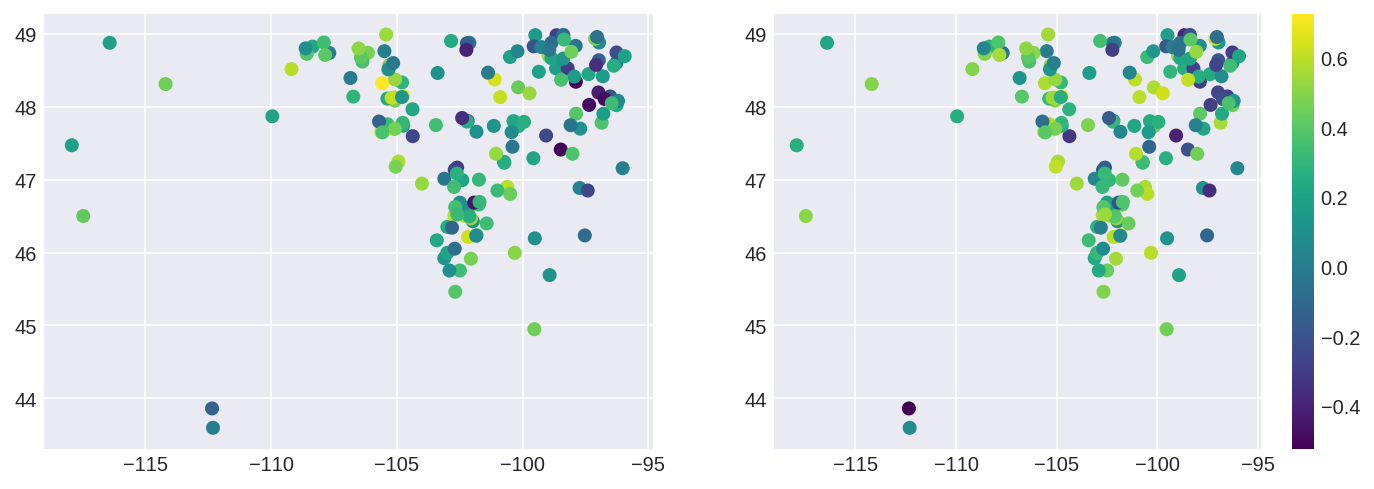

In [151]:
## scatterplot a few above shows shrinkage better than this
fig, (ax1,ax2) = plt.subplots(ncols=2, nrows=1, figsize=(12,4))
im1 = ax1.scatter(d.Longitude,d.Latitude,cmap='coolwarm',c=trace_h_normal['w_i'].mean(axis=0)[:,1])
im2 = ax2.scatter(d.Longitude,d.Latitude,cmap='coolwarm',c=b1)
fig.colorbar(mappable=im2);